In [2]:
from tqdm import tqdm
import numpy as np
from lmfit import minimize, Parameters, fit_report, Model
import pickle
import os
from pyne2001 import get_dm_full
import json
import corner

from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, Planck15
import astropy.units as u

from scipy.signal import savgol_filter, resample, correlate
from scipy.fft import fft2, fftshift

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

import utils.scinttools as sct
import utils.burstfittools as bft

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['cmr10']
rcParams['font.size'] = 25
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = False
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.usetex'] = False

/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: v0.0.0-44-gc4edec3-dirty is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: v1.4.0-7-g6469766 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.2.1-6-g1a8a603-dirty is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.2.1-6-g1a8a603 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resour

In [3]:
# Load data
name = "mizu_231120aabi"
data = np.load(f"./data/{name}/{name.split('_')[0]}_14000_16500.npy")

[<AxesSubplot:> <AxesSubplot:>]
[<AxesSubplot:> <AxesSubplot:>]


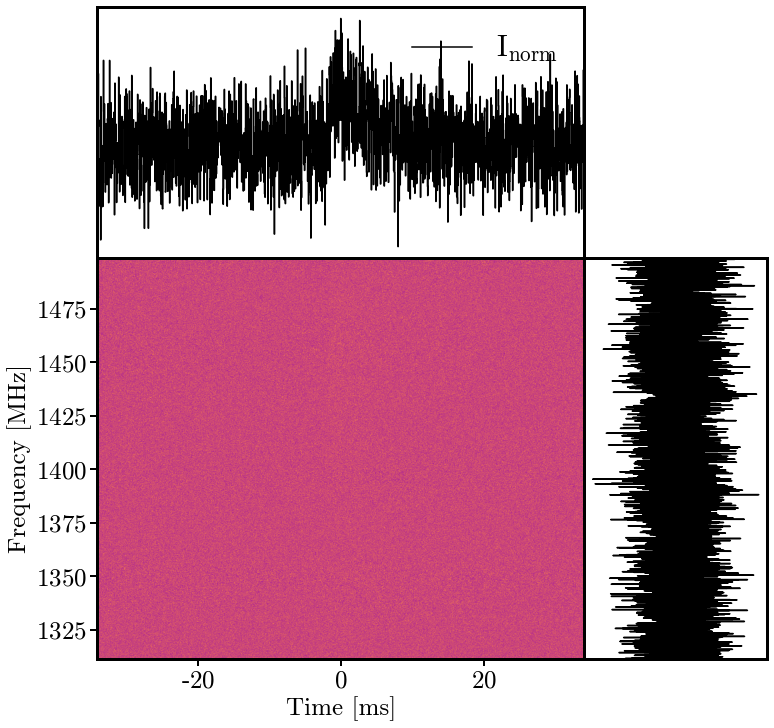

In [9]:
tres = 32.768e-3 #ms #data['delta_t (ms)']
fres = 0.03051757812 #MHz #data['delta_f (MHz)']
fres_kHz = fres*1e3

intensity = data #data['I']
outerbound = int(intensity.shape[1] * 1/12)

intensity = intensity[:, outerbound:-outerbound]

timeseries = np.nansum(intensity, axis = 0)
timesamples = np.linspace(0, intensity.shape[1]*tres, intensity.shape[1])
timerange = np.abs(timesamples[-1] - timesamples[0])
timesamples_mod = np.linspace(-timerange/2, timerange/2, len(timesamples))
timeshift = -1 * int(timesamples_mod[np.argmax(timeseries)] / tres)

intensity = np.roll(intensity, timeshift, axis = 1)
intensity_norm = intensity / np.nanmax(intensity)
spectrum = np.nansum(intensity, axis = 1)
spectrum_norm = spectrum / np.nanmax(spectrum)
freqsamples = np.linspace(1311.25, 1498.75, intensity.shape[0])
timeseries = np.nansum(intensity, axis = 0)
timeseries_norm = timeseries / np.nanmax(timeseries)

from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=2, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2], 'width_ratios':[2, 0.75]},
        figsize = (12, 12))

# Increase border thickness
current_axes = plt.gca()
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
for ax_row in axes:
    print(ax_row)
    for ax in ax_row:
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis = 'y', length=5)

axes[0, 0].step(timesamples_mod, timeseries_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0, 0].set_yticks([0, 1])
axes[0, 0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 0].set_yticks([])
axes[0, 0].set_xlim(timesamples_mod[0], timesamples_mod[-1])
axes[0, 0].legend(loc = 'upper right', fontsize = 30, frameon = False)

mean = np.nanmean(intensity_norm)
std = np.nanstd(intensity_norm)
axes[1, 0].imshow(intensity_norm, vmin = mean - 2*std, vmax = mean + 2*std, extent = [timesamples_mod[0], timesamples_mod[-1], freqsamples[0], freqsamples[-1]], cmap = 'plasma', aspect = 'auto') 
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')
axes[1, 0].tick_params(which='both', width=2)
axes[1, 0].tick_params(which='major', length=7)
axes[1, 0].tick_params(which='minor', length=5)
axes[1, 0].tick_params(which='minor', axis = 'y', length=5)

axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

axes[1, 1].step(np.flip(spectrum_norm), freqsamples, where='pre', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[1, 1].tick_params(axis='y',
        which='both', 
        left=False, 
        right=False, 
        labelleft=False,
        width=2)
axes[1, 1].set_xticks([])
axes[1, 1].set_ylim(freqsamples[0], freqsamples[-1])
#axes[2].legend(loc = 'upper right', fontsize = 30, frameon = False)

#axes[1].set_xlim(40, 150)
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

In [10]:
f_factor = 380
t_factor = 16
intensity_ds = bft.downsample_data(intensity, f_factor = f_factor, t_factor = t_factor)

Power Shape (frequency axis): 6144
Power Shape (time axis): 2084
Nearest Multiple To Downsampling Factor (frequency): 6080
Nearest Multiple To Downsampling Factor (time): 2080
Downsampled Data Shape: (16, 130)


[<AxesSubplot:> <AxesSubplot:>]
[<AxesSubplot:> <AxesSubplot:>]


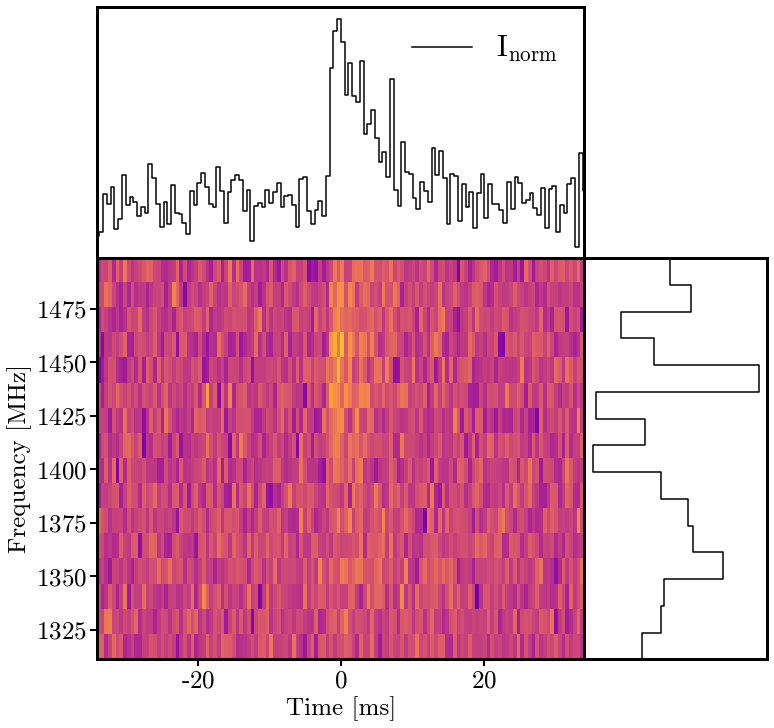

In [11]:
fres_ds = fres * f_factor
tres_ds = tres * t_factor

intensity_ds_norm = intensity_ds / np.max(intensity_ds)
timeseries_ds = np.nansum(intensity_ds, axis = 0)
timeseries_ds_norm = timeseries_ds / np.max(timeseries_ds)
timesamples_ds = np.linspace(0, intensity_ds.shape[1]*tres_ds, intensity_ds.shape[1])
timerange_ds = np.abs(timesamples_ds[-1] - timesamples_ds[0])
timesamples_mod_ds = np.linspace(-timerange_ds/2, timerange_ds/2, len(timesamples_ds))
spectrum_ds = np.nansum(intensity_ds, axis = 1)
spectrum_ds_norm = spectrum_ds / np.max(spectrum_ds)
freqsamples_ds = np.linspace(1311.25, 1498.75, intensity_ds.shape[0])

spectrum = np.nansum(intensity_ds, axis = 1)
timeseries = np.nansum(intensity_ds, axis = 0)

from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=2, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2], 'width_ratios':[2, 0.75]},
        figsize = (12, 12))

# Increase border thickness
current_axes = plt.gca()
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
for ax_row in axes:
    print(ax_row)
    for ax in ax_row:
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis = 'y', length=5)

axes[0, 0].step(timesamples_mod_ds, timeseries_ds_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0, 0].set_yticks([0, 1])
axes[0, 0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 0].set_yticks([])
axes[0, 0].set_xlim(timesamples_mod_ds[0], timesamples_mod_ds[-1])
axes[0, 0].legend(loc = 'upper right', fontsize = 30, frameon = False)

mean_ds = np.nanmean(intensity_ds_norm)
std_ds = np.nanstd(intensity_ds_norm)
axes[1, 0].imshow(intensity_ds_norm, vmin = mean_ds - 6*std_ds, vmax = mean_ds + 6*std_ds, extent = [timesamples_mod_ds[0], timesamples_mod_ds[-1], freqsamples_ds[0], freqsamples_ds[-1]], cmap = 'plasma', aspect = 'auto') 
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')
axes[1, 0].tick_params(which='both', width=2)
axes[1, 0].tick_params(which='major', length=7)
axes[1, 0].tick_params(which='minor', length=5)
axes[1, 0].tick_params(which='minor', axis = 'y', length=5)

axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

axes[1, 1].step(np.flip(spectrum_ds_norm), freqsamples_ds, where='pre', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[1, 1].tick_params(axis='y',
        which='both', 
        left=False, 
        right=False, 
        labelleft=False,
        width=2)
axes[1, 1].set_xticks([])
axes[1, 1].set_ylim(freqsamples_ds[0], freqsamples_ds[-1])
#axes[2].legend(loc = 'upper right', fontsize = 30, frameon = False)

#axes[1].set_xlim(40, 150)
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

In [12]:
n_channels = intensity_ds.shape[0]
n_samples = intensity_ds.shape[1]

# Create time array (ms)
time = np.linspace(0, n_samples*tres_ds, n_samples)

# Create frequency array with 128 channels
f_b = 1.31125  # GHz
f_t = 1.49875    # GHz
freq = np.linspace(f_b, f_t, n_channels)

# Set parameters for Model 3
#c0 = 1.0  # Reference flux at reference frequency
#spectral_index = 2.5
#t0 = 1.0  # ms
dm_init = 0.0
#DM_err = 0.0
#zeta = 0.08
#tau_1GHz = 0.6
#alpha = 4.0

# Parameters array for model 3
#params = [c0, spectral_index, t0, DM_err, zeta, tau_1GHz, alpha]

# Initialize the model and data
#data = np.zeros((N_channels, N_time_samples))
model_instance = bft.FRBModel(intensity_ds_norm, time, freq, dm_init)

# Add Gaussian noise to the simulated data
#np.random.seed(42)  # For reproducibility
#noise_level = 0.05 * np.max(simulated_data)  # Adjust noise level as needed
#noise = noise_level * np.random.randn(*simulated_data.shape)
#simulated_data_noisy = simulated_data + noise
#simulated_data_timeseries = simulated_data_noisy.sum(0) / np.max(simulated_data_noisy.sum(0))

32.81454387596899


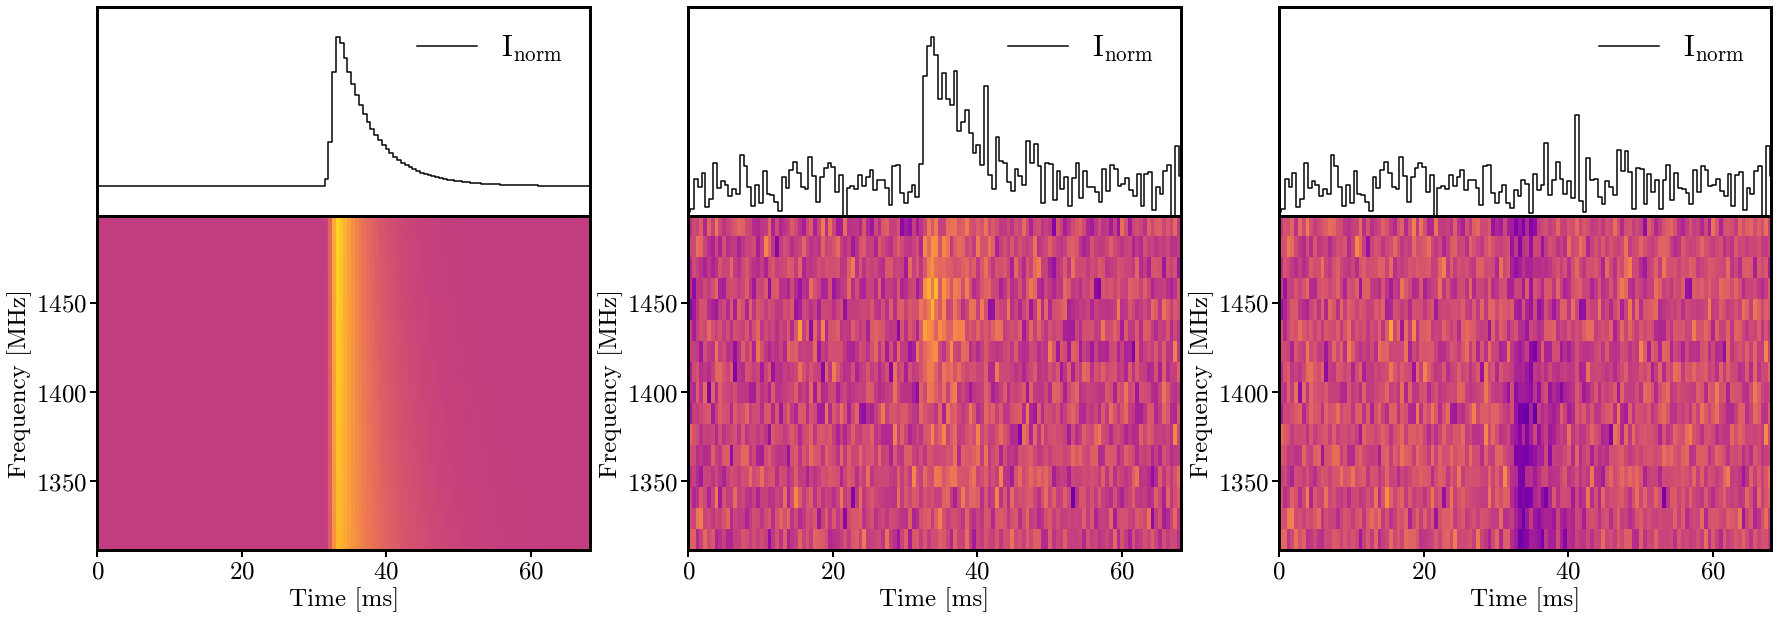

In [19]:
# Generate simulated data
c0_init = np.max(np.sum(intensity_ds_norm, axis=1)) / intensity_ds_norm.shape[1]
t0_init = timesamples_ds[np.argmax(np.sum(intensity_ds_norm, axis=0))] - 1
print(t0_init)
gamma_init = -2
DM_err_init = 0.0
zeta_init = 0.5
tau_init = 18
alpha_init = 4.0

model_type = 'model3'

sim_params = None
    
if model_type == 'model0':
    sim_params = [c0_init, t0_init, gamma_init, DM_err_init, 0., 0., 0.]

elif model_type == 'model1':
    sim_params = [c0_init, t0_init, gamma_init, DM_err_init, zeta_init, 0., 0.]

elif model_type == 'model2':
    sim_params = [c0_init, t0_init, gamma_init, DM_err_init, tau_init, alpha_init, 0.]

elif model_type == 'model3':
    sim_params = [c0_init, t0_init, gamma_init, DM_err_init, zeta_init, tau_init, alpha_init]

simulated_data = model_instance.model(sim_params, model_type=model_type)
simulated_data_norm = simulated_data / np.max(simulated_data)

sim_fres = fres_ds
sim_tres = tres_ds
sim_timeseries = np.nansum(simulated_data, axis = 0)
sim_timeseries_norm = sim_timeseries / np.max(sim_timeseries)
sim_timesamples = np.linspace(0, simulated_data.shape[1]*sim_tres, simulated_data.shape[1])
sim_timerange = np.abs(sim_timesamples[-1] - sim_timesamples[0])
sim_timesamples_mod = np.linspace(-sim_timerange/2, sim_timerange/2, len(sim_timesamples))
sim_spectrum = np.nansum(simulated_data, axis = 1)
sim_spectrum_norm = sim_spectrum / np.max(sim_spectrum)
sim_freqsamples = np.linspace(1311.25, 1498.75, simulated_data.shape[0])

# Compute residuals
intensity_rsdl = intensity_ds_norm - simulated_data_norm
timeseries_rsdl = timeseries_ds_norm - sim_timeseries_norm

from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=3, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2]},
        figsize = (30, 10))

# Increase border thickness
current_axes = plt.gca()
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis = 'y', length=5)

axes[0, 0].step(sim_timesamples, sim_timeseries_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0, 0].set_yticks([0, 1])
axes[0, 0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 0].set_yticks([])
axes[0, 0].set_ylim(-0.2, 1.2)
axes[0, 0].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 0].legend(loc = 'upper right', fontsize = 30, frameon = False)

sim_mean = np.nanmean(simulated_data_norm)
sim_std = np.nanstd(simulated_data_norm)
axes[1, 0].imshow(simulated_data_norm, vmin = sim_mean - 6*sim_std, vmax = sim_mean + 6*sim_std, extent = [sim_timesamples[0], sim_timesamples[-1], sim_freqsamples[0], sim_freqsamples[-1]], cmap = 'plasma', aspect = 'auto') 
#cbar = plt.colorbar(im1, ax=axes[1, 0])
#cbar.set_label('Intensity', rotation=270, labelpad=15)
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')

axes[0, 1].step(timesamples_ds, timeseries_ds_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0, 1].set_yticks([0, 1])
axes[0, 1].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 1].set_yticks([])
axes[0, 1].set_ylim(-0.2, 1.2)
axes[0, 1].set_xlim(timesamples_ds[0], timesamples_ds[-1])
axes[0, 1].legend(loc = 'upper right', fontsize = 30, frameon = False)

mean_ds = np.nanmean(intensity_ds_norm)
std_ds = np.nanstd(intensity_ds_norm)
axes[1, 1].imshow(intensity_ds_norm, vmin = mean_ds - 6*std_ds, vmax = mean_ds + 6*std_ds, extent = [sim_timesamples[0], sim_timesamples[-1], sim_freqsamples[0], sim_freqsamples[-1]], cmap = 'plasma', aspect = 'auto') 
axes[1, 1].set_ylabel('Frequency [MHz]')
axes[1, 1].set_xlabel('Time [ms]')

axes[0, 2].step(sim_timesamples, timeseries_rsdl, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0, 2].set_yticks([0, 1])
axes[0, 2].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 2].set_yticks([])
axes[0, 2].set_ylim(-0.2, 1.2)
axes[0, 2].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 2].legend(loc = 'upper right', fontsize = 30, frameon = False)

sim_mean = np.nanmean(intensity_rsdl)
sim_std = np.nanstd(intensity_rsdl)
axes[1, 2].imshow(intensity_rsdl, vmin = sim_mean - 6*sim_std, vmax = sim_mean + 6*sim_std, extent = [sim_timesamples[0], sim_timesamples[-1], sim_freqsamples[0], sim_freqsamples[-1]], cmap = 'plasma', aspect = 'auto') 
axes[1, 2].set_ylabel('Frequency [MHz]')
axes[1, 2].set_xlabel('Time [ms]')

#axes[1].set_xlim(40, 150)
plt.subplots_adjust(hspace=0)


In [20]:
# Fit the models
prior_bounds = {
        'c0': (1e-3, 100),  # Adjusted as per prior
        't0': (time[0], time[-1]),
        'spectral_index': (-5, 5),
        'DM_err': (-0.001, 0.001),
        'zeta': (0, 1),
        'tau_1GHz': (0, 20),
        'alpha': (3, 5)
    }

nsteps = 200


results, best_model = bft.fit_models(model_instance, sim_params, prior_bounds, numsteps=nsteps, fit_m0=False, fit_m1=False, fit_m2=False, fit_m3=True)
print(f"The best-fitting model is: {best_model}")

Check Prior Bounds:  {'c0': (0.001, 100), 't0': (0.0, 68.15744), 'spectral_index': (-5, 5), 'DM_err': (-0.001, 0.001), 'zeta': (0, 1), 'tau_1GHz': (0, 20), 'alpha': (3, 5)}
Fitting Model 3


100%|██████████| 200/200 [00:39<00:00,  5.09it/s]

Best model is model3
The best-fitting model is: model3


In [22]:
# Extract the sampler
best_sampler = results[best_model]['sampler']

print("Mean acceptance fraction (should be 0.2-0.5):", np.mean(best_sampler.acceptance_fraction))

# Check for NaN or Inf in Sampler
log_probs = best_sampler.get_log_prob()
if np.any(~np.isfinite(log_probs)):
    print("Found NaN or Inf in log-probabilities.")

#samples = best_sampler.get_chain(flat=True)
# Discard burn-in samples
burn_in = nsteps // 2
# Extract the samples
samples = best_sampler.get_chain(discard=burn_in, flat=True)
# Extract the log probability
log_prob = best_sampler.get_log_prob(discard=burn_in, flat=True)

# Determine the indices of the relevant parameters
if best_model == 'model0':
    param_indices = [0, 1, 2, 3]  # c0, spectral_index, t0, DM_err
elif best_model == 'model1':
    param_indices = [0, 1, 2, 3, 4]  # + zeta
elif best_model == 'model2':
    param_indices = [0, 1, 2, 3, 4, 5]  # + tau_1GHz, alpha
elif best_model == 'model3':
    param_indices = [0, 1, 2, 3, 4, 5, 6]  # + zeta, tau_1GHz, alpha

# Extract the relevant samples
relevant_samples = samples[:, param_indices]

# Extract the relevant true parameter values
#truths = [params[i] for i in param_indices]

# Define labels for the parameters
labels = ['c0', 't0', 'spectral_index', 'DM_err']
if best_model in ['model1', 'model3']:
    labels.append('zeta')
if best_model in ['model2', 'model3']:
    labels.extend(['tau_1GHz', 'alpha'])

# Plot trace plots to assess convergence
#ndim = relevant_samples.shape[1]
#fig, axes = plt.subplots(ndim, figsize=(15, 10), sharex=True)
#for i in range(ndim):
#    axes[i].plot(samples[:, i], "k", alpha=0.3)
#    axes[i].set_ylabel(labels[i])
#axes[-1].set_xlabel("Step number")
#plt.show()

Mean acceptance fraction (should be 0.2-0.5): 0.24064285714285719


In [23]:
# Calculate parameter estimates and their uncertainties
best_fit_params = []
best_fit_params_dict = {}
for i, label in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{label} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")
    best_fit_params.append(mcmc[1])
    best_fit_params_dict[f'{label}'] = (mcmc[1], +q[1], -q[0])

# Generate simulated data
initial_params = {}
initial_params['c0_init'] = c0_init
initial_params['t0_init'] = t0_init
initial_params['gamma_init'] = gamma_init
initial_params['DM_err_init'] = DM_err_init
initial_params['zeta_init'] = zeta_init
initial_params['tau_init'] = tau_init
initial_params['alpha_init'] = alpha_init

best_fit_params_dict['initial_params'] = initial_params
best_fit_params_dict['prior_bounds'] = prior_bounds

with open(f'{name.split("_")[0]}_best_fit_params.json', 'w') as f:
    json.dump(best_fit_params_dict, f)

c0 = 1.252 (+7.914, -0.273)
t0 = 32.961 (+0.366, -8.239)
spectral_index = 0.023 (+2.072, -1.726)
DM_err = 0.000 (+0.000, -0.000)
zeta = 0.521 (+0.169, -0.454)
tau_1GHz = 15.100 (+2.574, -4.098)
alpha = 3.645 (+0.297, -0.292)


Best Fit Params: [1.252314919198345, 32.96097373187715, 0.022926204219917423, 0.000150024984878399, 0.521444452371354, 15.099556327303649, 3.6453283356636073]


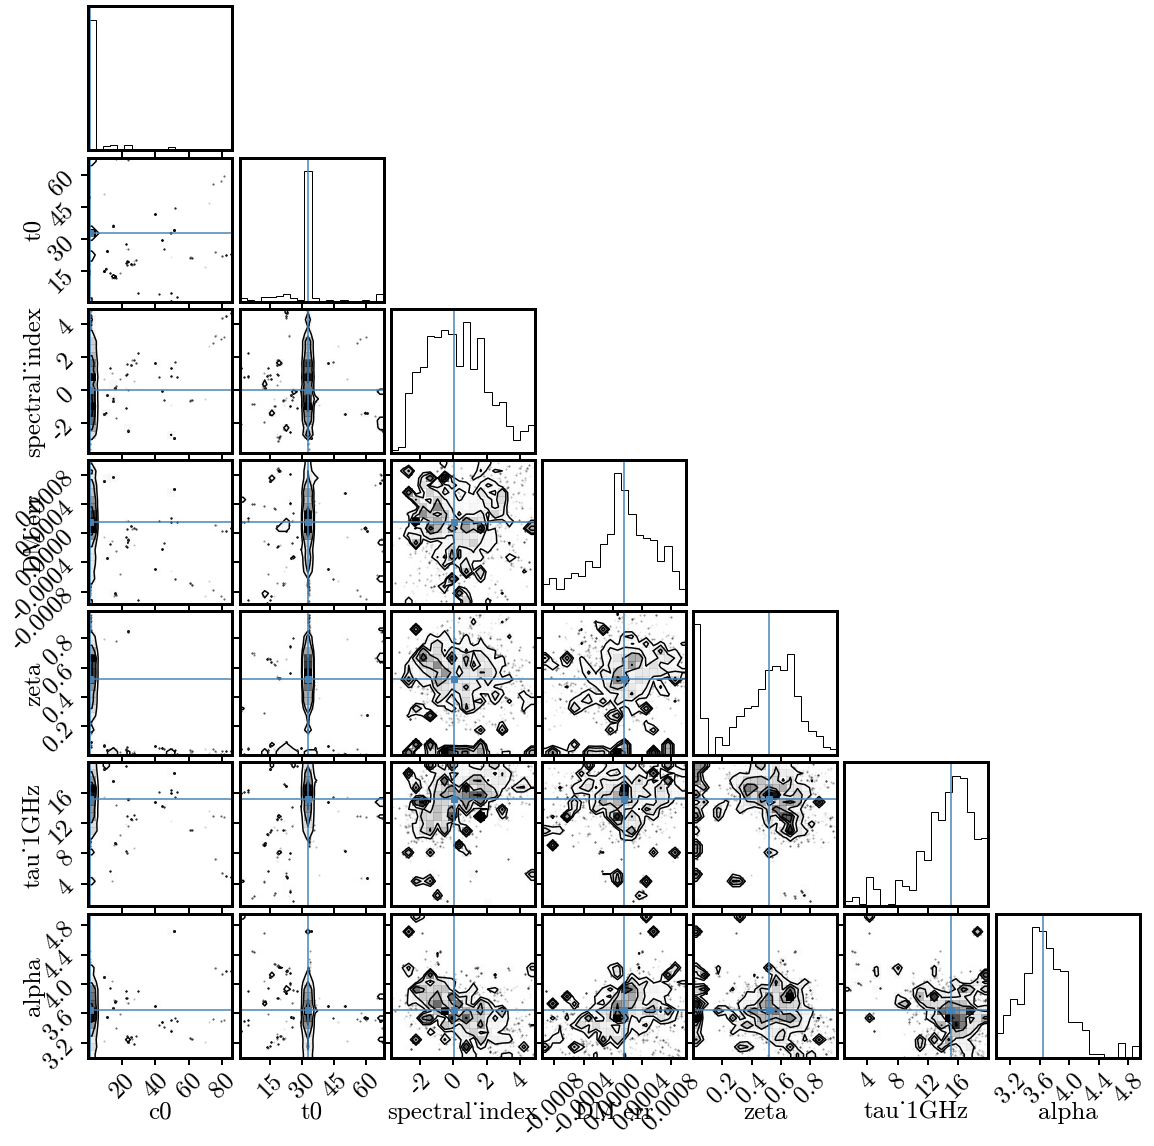

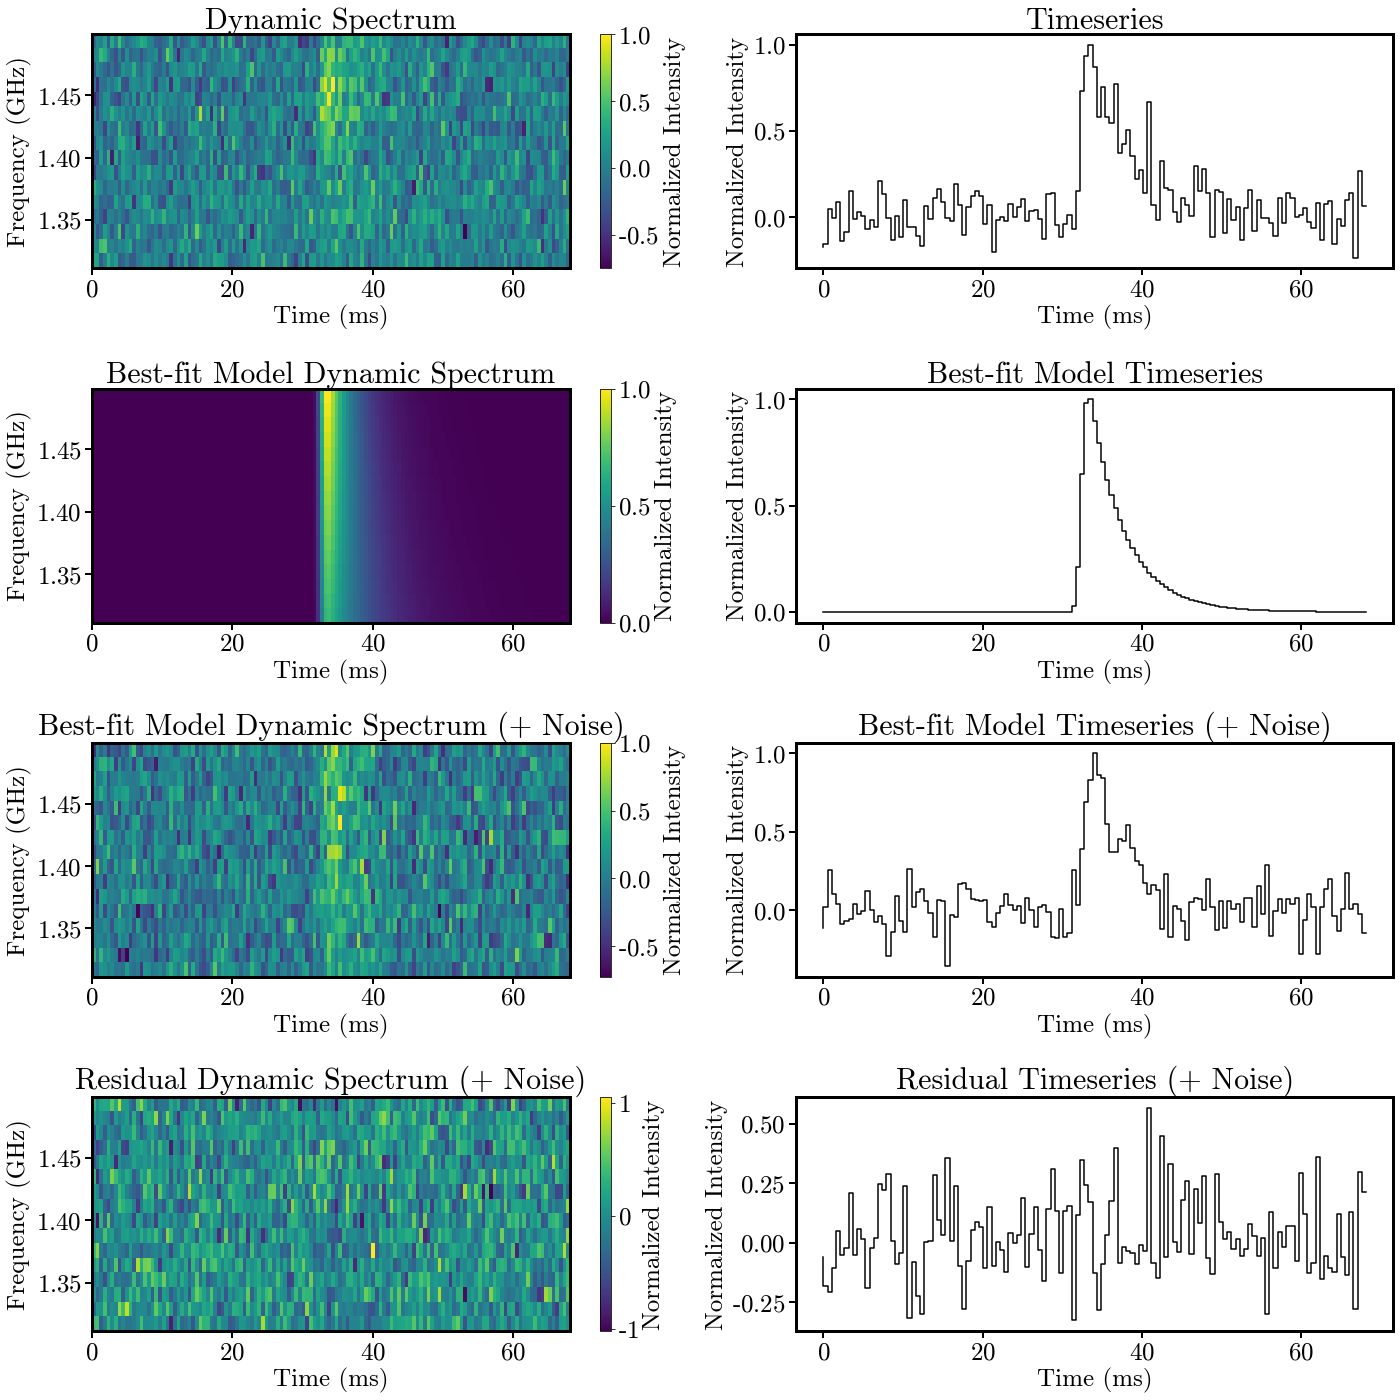

Mean acceptance fraction: 0.24064285714285719


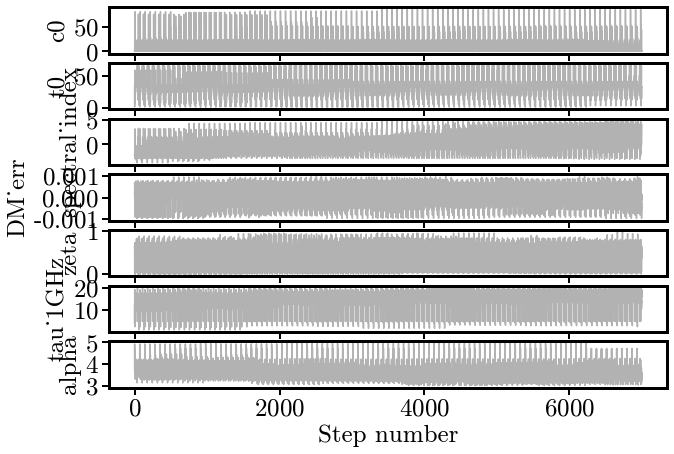

In [24]:
# Plot the data and the best-fit model
#best_fit_index = np.argmax(best_sampler.get_log_prob(discard=burn_in, flat=True))
#best_fit_index = np.argmax(log_prob)
#best_fit_params = samples[best_fit_index]

print(f'Best Fit Params: {best_fit_params}')

# Plot the corner plot
fig = corner.corner(relevant_samples, labels=labels, truths=best_fit_params)

for ax in fig.axes:
    # Spine widths
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

    # Tick parameters
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='minor', axis='y', length=5)

plt.show()

# Compute the model spectrum using the best-fit parameters
best_fit_model = model_instance.model(best_fit_params, model_type=best_model)

# Normalized data
norm_data = model_instance.data / np.max(model_instance.data)
norm_data_timeseries = model_instance.data.sum(0) / np.max(model_instance.data.sum(0))

# Normalized model
norm_model = best_fit_model / np.max(best_fit_model)
norm_model_timeseries = best_fit_model.sum(0) / np.max(best_fit_model.sum(0))

# Plot the data and the best-fit model separately for comparison
plt.figure(figsize=(20, 20))

for i in range(1, 9):
    plt.subplot(4, 2, i)
    ax = plt.gca()
    
    # Spine widths
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

    # Tick parameters
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='minor', axis='y', length=5)

# Plot the data
plt.subplot(4, 2, 1)
extent = [time[0], time[-1], freq[0], freq[-1]]
plt.imshow(norm_data, extent=extent, aspect='auto', origin='upper', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (GHz)')
plt.title('Dynamic Spectrum')

plt.subplot(4, 2, 2)
plt.step(time, norm_data_timeseries, c='k')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.title('Timeseries')

# Plot the best-fit model
plt.subplot(4, 2, 3)
plt.imshow(norm_model, extent=extent, aspect='auto', origin='upper', cmap='viridis')
#plt.imshow(norm_noisy_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (GHz)')
plt.title('Best-fit Model Dynamic Spectrum')

plt.subplot(4, 2, 4)
plt.step(time, norm_model_timeseries, c='k')
#plt.plot(time, norm_noisy_timeseries)
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.title('Best-fit Model Timeseries')

# Plot the best-fit model with added noise (based on the original data)
# Generate synthetic noise with the same shape as the model
noise = np.random.normal(loc=0.0, scale=model_instance.noise_std[:, np.newaxis], size=best_fit_model.shape)

# Add the synthetic noise to the fitted model
noisy_model = best_fit_model + noise
norm_noisy_model = noisy_model / np.max(noisy_model)

# Integrate to get the noisy timeseries
noisy_timeseries = np.nansum(norm_noisy_model, axis = 0)
norm_noisy_timeseries = noisy_timeseries / np.max(noisy_timeseries)

plt.subplot(4, 2, 5)
#plt.imshow(norm_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.imshow(norm_noisy_model, extent=extent, aspect='auto', origin='upper', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (GHz)')
plt.title('Best-fit Model Dynamic Spectrum (+ Noise)')

plt.subplot(4, 2, 6)
#plt.plot(time, norm_model_timeseries)
plt.step(time, norm_noisy_timeseries, c='k')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.title('Best-fit Model Timeseries (+ Noise)')

# Plot the residuals
plt.subplot(4, 2, 7)
plt.imshow(norm_data - norm_noisy_model, extent=extent, aspect='auto', origin='upper', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (GHz)')
plt.title('Residual Dynamic Spectrum (+ Noise)')

plt.subplot(4, 2, 8)
plt.step(time, norm_data_timeseries - norm_noisy_timeseries, c='k')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.title('Residual Timeseries (+ Noise)')

plt.tight_layout()
plt.show()

# Check the mean acceptance fraction
print("Mean acceptance fraction:", np.mean(best_sampler.acceptance_fraction))

# Trace plots to assess convergence
ndim = len(labels)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    axes[i].plot(samples[:, i], "k", alpha=0.3)
    axes[i].set_ylabel(labels[i])
    # Spine widths
    axes[i].spines['top'].set_linewidth(3)
    axes[i].spines['bottom'].set_linewidth(3)
    axes[i].spines['left'].set_linewidth(3)
    axes[i].spines['right'].set_linewidth(3)

    # Tick parameters
    axes[i].tick_params(which='both', width=2)
    axes[i].tick_params(which='major', length=7)
    axes[i].tick_params(which='minor', length=5)
    axes[i].tick_params(which='minor', axis='y', length=5)
axes[-1].set_xlabel("Step number")
plt.show()


In [30]:
print(intensity.shape)

(6144, 2084)


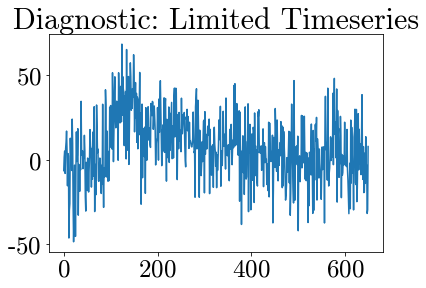

100%|██████████| 3072/3072 [00:00<00:00, 7034.72it/s]


[[Model]]
    Model(lorentz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 153
    # data points      = 130
    # variables        = 3
    chi-square         = 0.51308692
    reduced chi-square = 0.00404005
    Akaike info crit   = -713.529779
    Bayesian info crit = -704.927176
    R-squared          = 0.80963746
[[Variables]]
    gamma1:  40.7021989 +/- 9.78566337 (24.04%) (init = 1)
    m1:      1.70550958 +/- 0.30712767 (18.01%) (init = 1)
    c:       0.01988348 +/- 0.00621070 (31.24%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9928
    C(gamma1, c)  = -0.3337
    C(m1, c)      = +0.2969


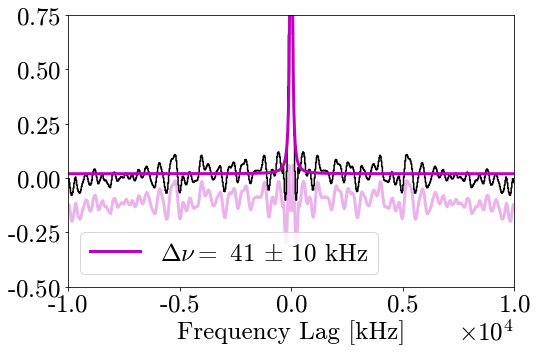

In [49]:
#spec_norm = spectrum / np.max(spectrum)
intensity_tshape = intensity.shape[1]
intensity_fshape = intensity.shape[0]
outer_bound_left = 150
outer_bound_right = 500
spectrum_lim = np.nansum(intensity[:intensity_fshape//2, intensity_tshape//2 - outer_bound_left:intensity_tshape//2 + outer_bound_right], axis=1)

fig = plt.figure()
plt.plot(np.nansum(intensity[:intensity_fshape//2, intensity_tshape//2 - outer_bound_left:intensity_tshape//2 + outer_bound_right], axis=0))
plt.title('Diagnostic: Limited Timeseries')
plt.show()

spec_norm = savgol_filter(spectrum_lim / np.max(spectrum_lim), 11, 3)
acf=sct.autocorr(spec_norm)
lags=np.arange(len(acf))+1
acf=acf[1:]
lags=lags[1:]
acf=np.concatenate((acf[::-1],acf))
lags=np.concatenate((-1*lags[::-1],lags))*fres_kHz

lag_range_for_fit=2000 #somewhat arbitrary, 2000 works well to successfully fit the central peak

gmodel = Model(sct.lorentz)
acf_for_fit = acf[int(len(acf)/2.)-int(lag_range_for_fit/fres_kHz):int(len(acf)/2.)+int(lag_range_for_fit/fres_kHz)]
lags_for_fit = lags[int(len(acf)/2.)-int(lag_range_for_fit/fres_kHz):int(len(acf)/2.)+int(lag_range_for_fit/fres_kHz)]
#result = gmodel.fit(acf_for_fit, x=lags_for_fit, gamma1=10, m1=1,gamma2=100,m2=1, c=0)
result = gmodel.fit(acf_for_fit, x=lags_for_fit, gamma1=1, m1=1,c=0)
print(result.fit_report())

fig = plt.figure(figsize = (8, 5))

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-4, 4))

label_str = r'$\Delta \nu =$ ' + str(round(result.params['gamma1'].value)) + r' $\pm$ ' + str(round(result.params['gamma1'].stderr)) + ' kHz'

plt.step(lags, acf, c = 'k')
plt.plot(lags, sct.lorentz(lags, result.params['gamma1'], result.params['m1'], result.params['c']), c = 'm', lw = 3, label = label_str)
plt.plot(lags, acf - sct.lorentz(lags, result.params['gamma1'], result.params['m1'], result.params['c']) - 0.1, c = 'm', alpha = 0.3, lw = 3)

plt.xlim(-10e3, 10e3)
plt.ylim(-0.5, 0.75)
plt.xlabel('Frequency Lag [kHz]')
plt.legend()
plt.show()

From Sammons et al. 2023

$L_x L_g \lesssim \frac{D_s^2}{2 \pi \nu^2(1+z)} \frac{\nu_{\mathrm{DC}}}{t_{\text {scatt }}}$.

In [54]:
def Lx(nu, dso, z, sbw, tau, Lg):
    lx = (dso**2 * sbw) / (Lg * (2 * np.pi * nu**2) * (1+z) * tau)
    return lx

localization = ['09h35m56.15s', '+73d17m04.8s']
z_source = 0.0368

gal_dist = 50 #kpc
coord_icrs = SkyCoord(localization[0], localization[1], frame = 'icrs')
coord_galactic = coord_icrs.galactic
ra_gal_deg = coord_galactic.l.deg
dec_gal_deg = coord_galactic.b.deg
output = get_dm_full(ra_gal_deg, dec_gal_deg, gal_dist)

print('NE2001 Sightline Estimates:')
print('________________________________')
print(f'SBW (1.4 GHz): {1e3 * output["SBW"]*(1.4)**best_fit_params_dict["alpha"][0]} kHz')
print(f'Tau (1.4 GHz): {output["TAU"]*(1.4)**(-1 * best_fit_params_dict["alpha"][0])} ms')
print('\n')

# Perform two-screen calculation
print('Two Screen Analysis (assuming measured SBW):')
print('________________________________')
# Define a cosmology, e.g., H0 = 70 km/s/Mpc and Omega_m = 0.3
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dso = cosmo.comoving_distance(z_source).to(u.kpc) # comoving distance
print(f'Comoving Distance to Source: {dso}')
sbw = result.params['gamma1'].value * u.kHz
print(f'Measured SBW (1.4 GHz): {sbw}')
nu = (1.4 * u.GHz).to(u.kHz)
print(f'Observing Frequency: {nu}')
tau_1p4GHz = best_fit_params_dict['tau_1GHz'][0] * 1.4**(-1*best_fit_params_dict['alpha'][0]) * u.ms
print(f'Measured Tau (1.4 GHz): {tau_1p4GHz}')
lg = 1 * u.kpc
print(f'L_g (MW Thick Disk): {lg}')
lx = Lx(nu, dso, z_source, sbw, tau_1p4GHz, lg)
lx_kpc = lx.to(u.kpc)
print(f'Upper Limit on Source-to-Screen Distance: {lx_kpc}')
print('\n')





NE2001 Sightline Estimates:
________________________________
SBW (1.4 GHz): 3313.6470739573447 kHz
Tau (1.4 GHz): 5.569808910868214e-05 ms


Two Screen Analysis (assuming measured SBW):
________________________________
Comoving Distance to Source: 156290.2529839281 kpc
Measured SBW (1.4 GHz): 40.70219885546253 kHz
Observing Frequency: 1400000.0 kHz
Measured Tau (1.4 GHz): 4.428733195469846 ms
L_g (MW Thick Disk): 1.0 kpc
Upper Limit on Source-to-Screen Distance: 0.01758211896974835 kpc




In [56]:
# Perform two-screen calculation
print('Two Screen Analysis (assuming SBW = fres):')
print('________________________________')
# Define a cosmology, e.g., H0 = 70 km/s/Mpc and Omega_m = 0.3
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dso = cosmo.comoving_distance(z_source).to(u.kpc) # comoving distance
print(f'Comoving Distance to Source: {dso}')
#sbw = result.params['gamma1'].value * u.kHz
sbw = fres_kHz * u.kHz
print(f'Measured SBW (1.4 GHz): {sbw}')
nu = (1.4 * u.GHz).to(u.kHz)
print(f'Observing Frequency: {nu}')
tau_1p4GHz = best_fit_params_dict['tau_1GHz'][0] * 1.4**(-1*best_fit_params_dict['alpha'][0]) * u.ms
print(f'Measured Tau (1.4 GHz): {tau_1p4GHz}')
lg = 1 * u.kpc
print(f'L_g (MW Thick Disk): {lg}')
lx = Lx(nu, dso, z_source, sbw, tau_1p4GHz, lg)
lx_kpc = lx.to(u.kpc)
print(f'Upper Limit on Source-to-Screen Distance: {lx_kpc}')
print('\n')

# Perform two-screen calculation
print('Two Screen Analysis (assuming SBW = burst band occupation ~ 93.75 MHz):')
print('________________________________')
# Define a cosmology, e.g., H0 = 70 km/s/Mpc and Omega_m = 0.3
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dso = cosmo.comoving_distance(z_source).to(u.kpc) # comoving distance
print(f'Comoving Distance to Source: {dso}')
#sbw = result.params['gamma1'].value * u.kHz
sbw = 93750 * u.kHz
print(f'Measured SBW (1.4 GHz): {sbw}')
nu = (1.4 * u.GHz).to(u.kHz)
print(f'Observing Frequency: {nu}')
tau_1p4GHz = best_fit_params_dict['tau_1GHz'][0] * 1.4**(-1*best_fit_params_dict['alpha'][0]) * u.ms
print(f'Measured Tau (1.4 GHz): {tau_1p4GHz}')
lg = 1 * u.kpc
print(f'L_g (MW Thick Disk): {lg}')
lx = Lx(nu, dso, z_source, sbw, tau_1p4GHz, lg)
lx_kpc = lx.to(u.kpc)
print(f'Upper Limit on Source-to-Screen Distance: {lx_kpc}')

Two Screen Analysis (assuming SBW = fres):
________________________________
Comoving Distance to Source: 156290.2529839281 kpc
Measured SBW (1.4 GHz): 30.51757812 kHz
Observing Frequency: 1400000.0 kHz
Measured Tau (1.4 GHz): 4.428733195469846 ms
L_g (MW Thick Disk): 1.0 kpc
Upper Limit on Source-to-Screen Distance: 0.013182670820311675 kpc


Two Screen Analysis (assuming SBW = burst band occupation ~ 93.75 MHz):
________________________________
Comoving Distance to Source: 156290.2529839281 kpc
Measured SBW (1.4 GHz): 93750.0 kHz
Observing Frequency: 1400000.0 kHz
Measured Tau (1.4 GHz): 4.428733195469846 ms
L_g (MW Thick Disk): 1.0 kpc
Upper Limit on Source-to-Screen Distance: 40.49716476663252 kpc
